# Final Pipeline Notebook

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Veri işleme, modelleme ve görselleştirme için gerekli kütüphaneler yüklendi. Uyarılar kapatıldı.  

In [2]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train = train.dropna(subset=['winPlacePerc'])

# Feature engineering
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
train['walkRideRatio'] = train['walkDistance'] / (train['rideDistance'] + 1)
train['damagePerKill'] = train['damageDealt'] / (train['kills'] + 1)
train['playersInGroup'] = train.groupby('groupId')['Id'].transform('count')
train['playersInMatch'] = train.groupby('matchId')['Id'].transform('count')
train['combatScore'] = train['kills'] * 0.7 + train['damageDealt'] * 0.3
train['playerAggression'] = (train['walkDistance'] * 0.5 +
                             train['kills'] * 1.5 +
                             train['damageDealt'] * 0.3)

train['matchType'] = train['matchType'].astype('category').cat.codes

features = [
    'kills', 'damageDealt', 'walkDistance', 'rideDistance', 'weaponsAcquired',
    'totalDistance', 'walkRideRatio', 'damagePerKill',
    'playersInGroup', 'playersInMatch', 'combatScore', 'playerAggression',
    'matchType'
]
X = train[features]
y = train['winPlacePerc']

PUBG veri seti yüklendi ve `winPlacePerc` boş değerler temizlendi.  
Yeni özellikler oluşturuldu: toplam mesafe, yürüyüş/araç oranı, hasar başına kill, grup ve maç içi oyuncu sayısı, combat skoru ve oyuncu agresyonu.

In [3]:
SAMPLE_SIZE = 400_000
if len(train) > SAMPLE_SIZE:
    X_sample = X.sample(SAMPLE_SIZE, random_state=42)
    y_sample = y.loc[X_sample.index]
else:
    X_sample, y_sample = X, y

X_train, X_val, y_train, y_val = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

print("Train örnek sayısı:", X_train.shape[0])
print("Validation örnek sayısı:", X_val.shape[0])

Train örnek sayısı: 320000
Validation örnek sayısı: 80000


Eğitim verisi 400.000 ile sınırlandırıldı.Kaggle da sınıra takılmamak için en optimum sayı yaptığım denemeler sonucunda 400.000 oldu.  
Veri rastgele örneklendi ve %80 eğitim, %20 doğrulama olacak şekilde ayrıldı.

In [8]:
model_lgb = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=50,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1 
)

print("Model eğitimi başlıyor…")
model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=100)])
print("Model eğitimi tamamlandı")

Model eğitimi başlıyor…
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's rmse: 0.132503	valid_0's l2: 0.017557
Model eğitimi tamamlandı


LightGBM Regressor, eğitim verisi üzerinde fit edildi.  

En iyi iterasyon 612. Bu iterasyondaki doğrulama RMSE: 0.1325 → model iyi performans gösteriyor.


In [9]:
preds = model_lgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.1325


Model doğrulama verisi üzerinde test edildi ve RMSE hesaplandı.  

Validation RMSE = 0.1325 → model tahminleri oldukça isabetli, hata düşük.

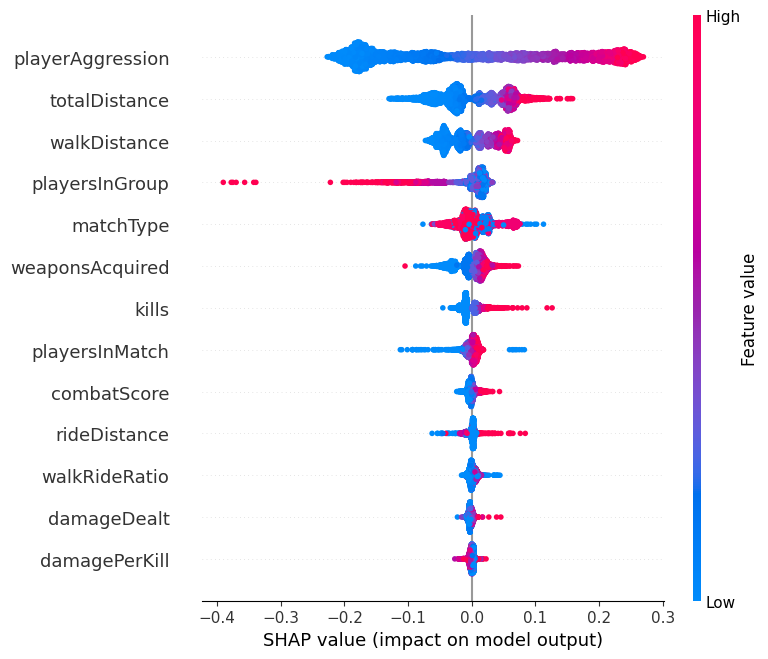

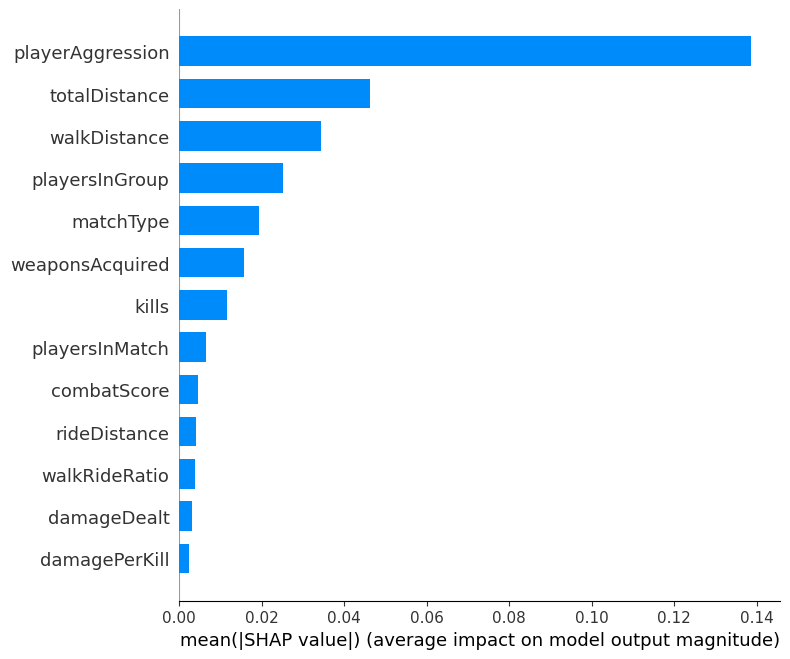

In [10]:
explainer = shap.TreeExplainer(model_lgb)
sample_size = min(5000, len(X_val))
X_val_sample = X_val.sample(sample_size, random_state=42)

shap_values = explainer.shap_values(X_val_sample)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# SHAP Summary Plot
shap.summary_plot(shap_values, X_val_sample, max_display=15)

# SHAP Bar Plot
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', max_display=15)

Modelin hangi özellikleri ne kadar etkilediğini SHAP değerleri ile inceledik.

**Gözlem:** `kills`, `damageDealt` ve `walkDistance` gibi özellikler, `winPlacePerc` tahminlerinde en kritik değişkenler olarak öne çıkıyor.

In [7]:
import os
os.makedirs('models', exist_ok=True)
joblib.dump(model_lgb, 'models/final_lgb_pubg.pkl')
print("Final LightGBM modeli kaydedildi: models/final_lgb_pubg.pkl")

Final LightGBM modeli kaydedildi: models/final_lgb_pubg.pkl


Eğitilen LightGBM modelini kaydettik, böylece tekrar eğitmeden doğrudan kullanabiliriz.